In [1]:
%%capture
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from tensorflow.keras import regularizers
import os
import time
from IPython.display import HTML, display
! pip install tabulate
import tabulate
import numpy as np
import gc
from tensorflow.keras.models import model_from_json
!pip install tqdm
!pip install h5py
import zipfile
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from sklearn import preprocessing
from tensorflow.keras.models import model_from_json

In [2]:
def scale(x):

    return (x - np.mean(x)) / np.std(x)

In [3]:
def preprocess(x):
    
    return x[:,:,:int(0.75*x.shape[2])]

In [4]:
os.chdir("/home/pk2573")
path = "/home/pk2573/Capstone_Data"

In [5]:
"""
def un_zip(file_path):
    path, fname = os.path.split(file_path)
    if (fname.endswith("zip")):
        zip_ref = zipfile.ZipFile(fname, 'r')
        zip_ref.extractall(path)
        zip_ref.close() 
            
    new_path = path + "/" + fname.split(".")[0]
    
    return new_path
"""

'\ndef un_zip(file_path):\n    path, fname = os.path.split(file_path)\n    if (fname.endswith("zip")):\n        zip_ref = zipfile.ZipFile(fname, \'r\')\n        zip_ref.extractall(path)\n        zip_ref.close() \n            \n    new_path = path + "/" + fname.split(".")[0]\n    \n    return new_path\n'

In [6]:
#path = un_zip(file_path)
#print(path)

In [7]:
json_file = open('model_tau_12.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_tau_12 = model_from_json(loaded_model_json)
model_tau_12.load_weights("model_tau_12.h5")
model_tau_12.compile(loss = 'mse', optimizer = tf.train.AdamOptimizer())

In [8]:
json_file = open('model_tau_13.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_tau_13 = model_from_json(loaded_model_json)
model_tau_13.load_weights("model_tau_13.h5")
model_tau_13.compile(loss = 'mse', optimizer = tf.train.AdamOptimizer())

In [9]:
json_file = open('model_tau_23.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_tau_23 = model_from_json(loaded_model_json)
model_tau_23.load_weights("model_tau_23.h5")
model_tau_23.compile(loss = 'mse', optimizer = tf.train.AdamOptimizer())

In [10]:
subdirs = [subdir for subdir, dirs, files in os.walk(path)]
subdirs.remove(path + "/Re554Fr5_coarse8/.ipynb_checkpoints")
subdirs.remove(path + "/Re309Fr2_coarse8/.ipynb_checkpoints")
subdirs.remove(path + "/Re546_coarse8/.ipynb_checkpoints")
subdirs.remove(path + "/.ipynb_checkpoints")
subdirs.remove(path + "/Re1243Fr20_coarse4")
subdirs = subdirs[1:]
subdirs

['/home/pk2573/Capstone_Data/Re1243Fr20_coarse16',
 '/home/pk2573/Capstone_Data/Re309Fr2_coarse8',
 '/home/pk2573/Capstone_Data/Re1243Fr20_coarse8',
 '/home/pk2573/Capstone_Data/Re554Fr5_coarse8',
 '/home/pk2573/Capstone_Data/Re1243Fr20_coarse24',
 '/home/pk2573/Capstone_Data/Re546_coarse8']

Running Re1243Fr20_coarse16
Running Re309Fr2_coarse8
Running Re1243Fr20_coarse8
Running Re554Fr5_coarse8
Running Re1243Fr20_coarse24
Running Re546_coarse8


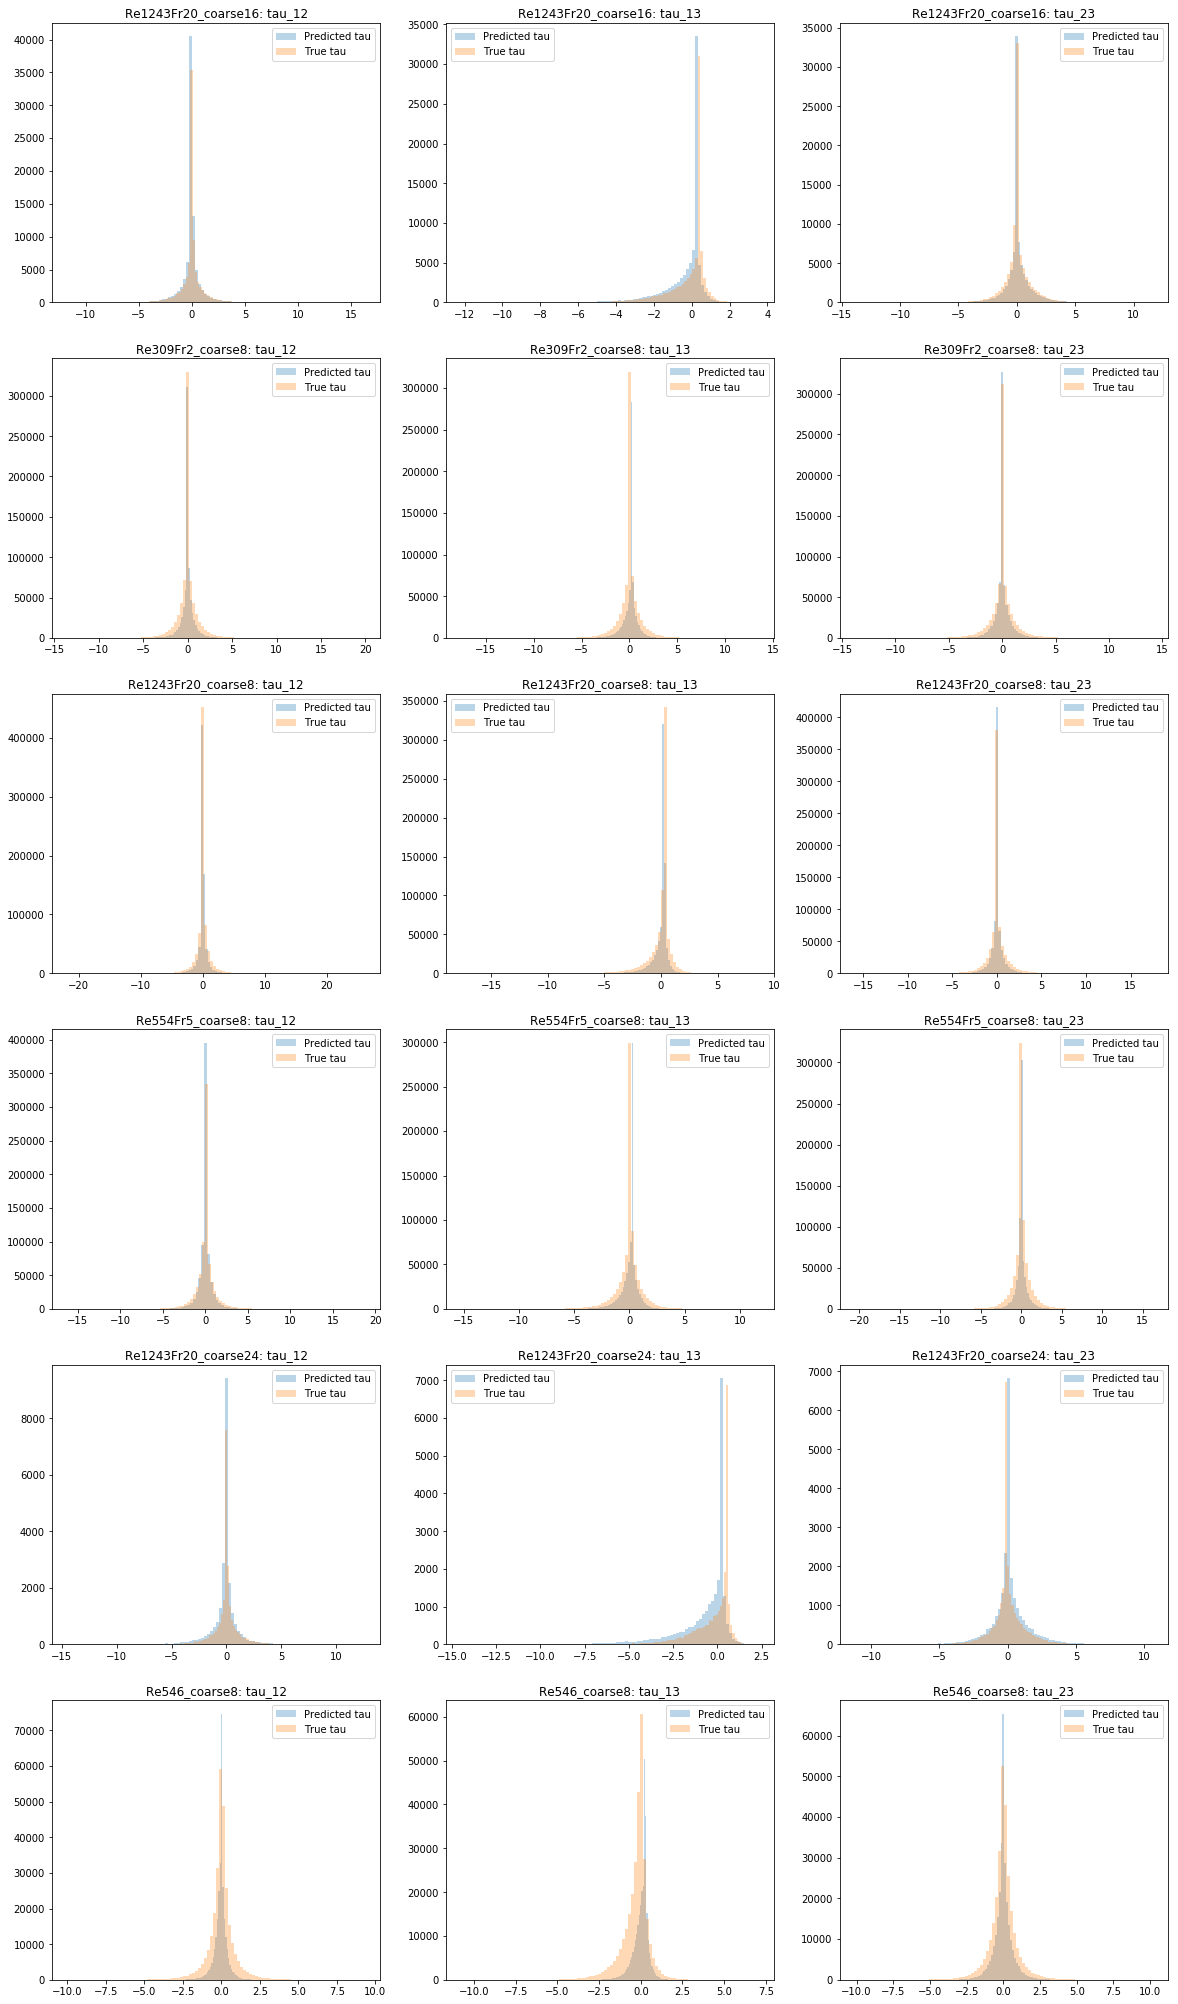

In [11]:
out = [["Data Source", "Tau_12", "Tau_13", "Tau_23"]]
fig = plt.figure(figsize = (20, 36))
count = 1
                 
for path in subdirs:
    print("Running " + path.split("/")[-1])
    os.chdir(path)
    
    u = loadmat('u_F_xyz_T1.mat')
    u = preprocess(scale(u[list(u.keys())[-1]]))
    v = loadmat('v_F_xyz_T1.mat')
    v = preprocess(scale(v[list(v.keys())[-1]]))
    w = loadmat('w_F_xyz_T1.mat')
    w = preprocess(scale(w[list(w.keys())[-1]]))
    tau_12 = loadmat('tau12_xyz_T1.mat')
    tau_12 = preprocess(scale(tau_12[list(tau_12.keys())[-1]]))
    tau_13 = loadmat('tau13_xyz_T1.mat')
    tau_13 = preprocess(scale(tau_13[list(tau_13.keys())[-1]]))
    tau_23 = loadmat('tau23_xyz_T1.mat')
    tau_23 = preprocess(scale(tau_23[list(tau_23.keys())[-1]]))
    
    x = np.array([u, v, w])
    x = np.transpose(x, [1, 2, 3, 0])
    x = np.pad(x, ((3,3), (3,3), (3,3), (0,0)), 'constant', constant_values = 0)
    
    del u
    del v
    del w
    gc.collect()
    
    sample = []
    size = 3
    y_tau_12 = []
    y_tau_13 = []
    y_tau_23 = []
    for i in range(size, x.shape[0] - size):
        for j in range(size, x.shape[1] - size):
            for k in range(size, x.shape[2] - size):
                sample.append(x[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
                y_tau_12.append(tau_12[i - size][j - size][k - size])
                y_tau_13.append(tau_13[i - size][j - size][k - size])
                y_tau_23.append(tau_23[i - size][j - size][k - size])
    
    x = np.array(sample)

    tau_12 = np.array(y_tau_12)
    tau_13 = np.array(y_tau_13)
    tau_23 = np.array(y_tau_23)
    
    del sample
    gc.collect()
    
    output = [(tau_12, "tau_12", model_tau_12), (tau_13, "tau_13", model_tau_13), (tau_23, "tau_23", model_tau_23)]
    
    corrs = []
    for (y_true, name, model) in output:
        y_pred = model.predict(x).flatten()
        corrs.append(np.corrcoef(y_pred, y_true)[0, 1])
        
        if count <= 18:
            fig.add_subplot(6, 3, count)
            n_bins = 100
            plt.hist(y_pred, bins = n_bins, alpha = 0.3, label = "Predicted tau")
            plt.hist(y_true, bins = n_bins, alpha = 0.3, label = "True tau")
            plt.title(path.split("/")[-1] + ": " + name)
            plt.legend()
            plt.show

            count += 1
    
    out.append([path.split("/")[-1], str(np.round(corrs[0], 4)), str(np.round(corrs[1], 4)), str(np.round(corrs[2], 4))])
        
    del x
    del tau_12
    del tau_13
    del tau_23
    del model
    del y_pred
    del y_true
    gc.collect()

In [13]:
display(HTML(tabulate.tabulate(out, tablefmt = 'html')))

Data Source,Tau_12,Tau_13,Tau_23
Re1243Fr20_coarse16,0.7249,0.8303,0.7898
Re309Fr2_coarse8,0.6965,0.7721,0.8014
Re1243Fr20_coarse8,0.8675,0.9073,0.8861
Re554Fr5_coarse8,0.7259,0.7883,0.8087
Re1243Fr20_coarse24,0.6551,0.7887,0.7221
Re546_coarse8,0.5666,0.6008,0.6397
